In [1]:
import numpy as np
import cv2
import os
import sys
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import clear_output
%matplotlib inline

sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from Thymio import Thymio

import vision

In [5]:
#RUN THIS CELL IF YOU MODIFIED MODULES AND DONT WANT TO RESTART KERNEL
import importlib
importlib.reload(vision)

<module 'vision' from '/Users/ken/Dropbox/EPFL/Basics_of_Mobile_Robotics/Project/vision.py'>

In [8]:
def variable_info(variable):
    """
    Provided a variable, prints the type and content of the variable
    """
    print("This variable is a {}".format(type(variable)))
    if type(variable) == np.ndarray:
        print("\n\nThe shape is {}".format(variable.shape))
    print("\n\nThe data contained in the variable is : ")
    print(variable)
    print("\n\nThe elements that can be accessed in the variable are :\n")
    print(dir(variable))
    
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks_x = np.arange(0, max_val*4/3+1, 5)
    minor_ticks_x = np.arange(0, max_val*4/3+1, 1)
    major_ticks_y = np.arange(0, max_val+1, 5)
    minor_ticks_y = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val*4/3])
    ax.grid(True)
    
    return fig, ax

def _get_movements_4n():
    """
    Get all possible 4-connectivity movements (up, down, left right).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N", max_val = 50):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet






def runAstar(start, goal, max_val, occupancy_grid, cmap):
    x,y = np.mgrid[0:max_val:1, 0:max_val:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])

    # Define the heuristic, here = distance to goal ignoring obstacles
    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))

    # Run the A* algorithm
    path, visitedNodes = A_Star(start, goal, h, coords, cv2.flip(occupancy_grid, 0).transpose(), movement_type="8N")
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

    # Displaying the map
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(cv2.flip(occupancy_grid, 0), cmap=cmap)

    # Plot the best path found and the list of visited nodes
    #ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    return path


# Detect Thymio position

The Thymio is detected by detecting the green circle (center of mass) and the blue point to detect the orientation. 

#### Read image and display it

<Figure size 432x288 with 0 Axes>

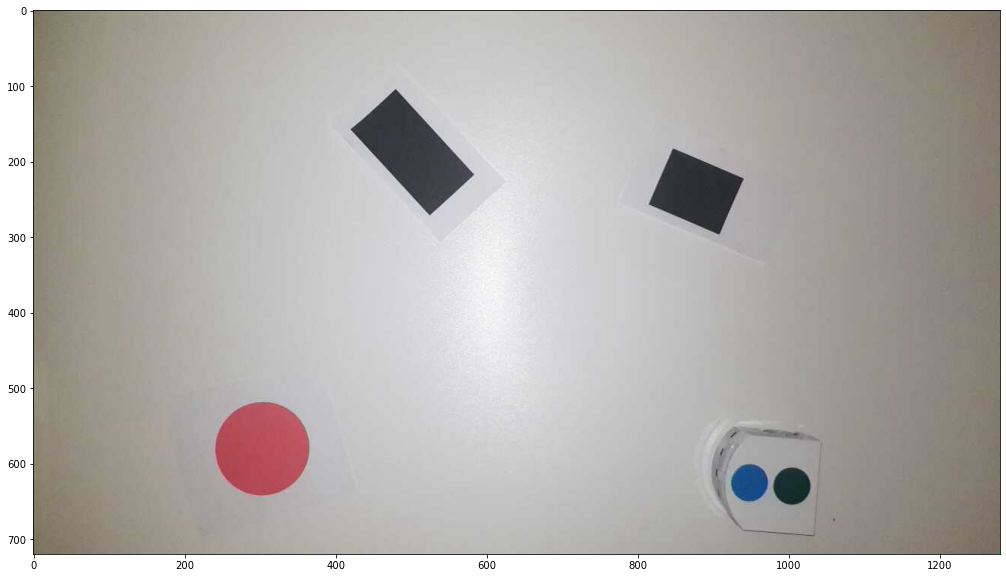

In [2]:
%matplotlib inline
cap = vision.VideoCapture("http://192.168.13.124:8080/video")
plt.figure()

viewCam = False

while viewCam:
    frame = cap.read()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    plt.imshow(frame)
    plt.show()
    time.sleep(1)
    clear_output()
    
raw_frame = cap.read()
plt.figure(figsize = (50,10))
plt.imshow(cv2.cvtColor(raw_frame,cv2.COLOR_BGR2RGB))
plt.show()

[[[303.   580.2   60.24]]]


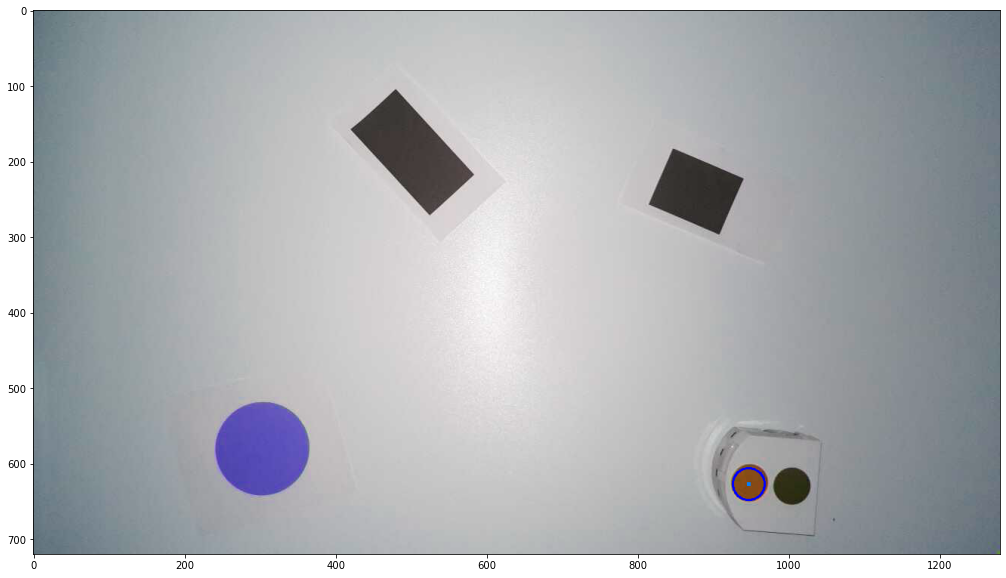

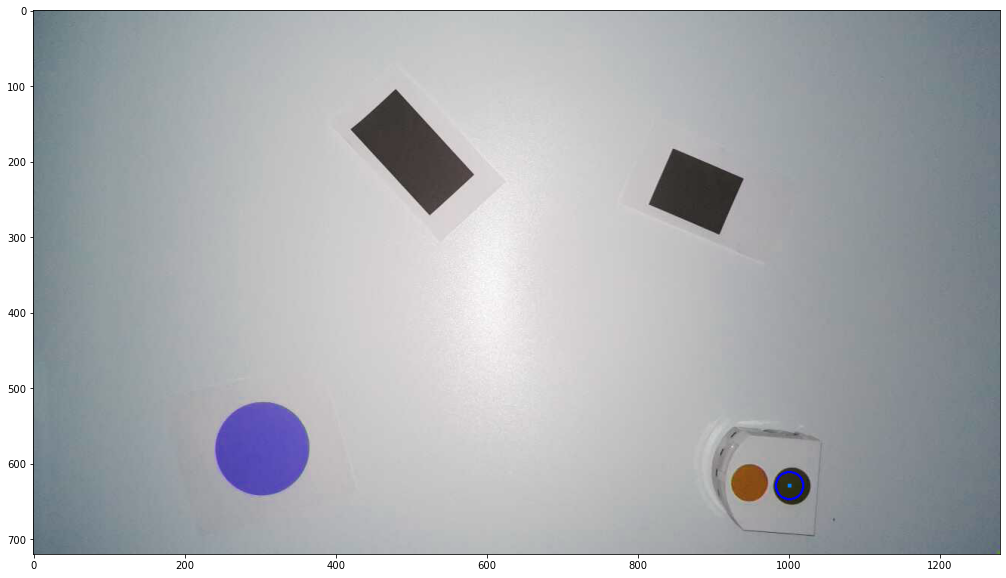

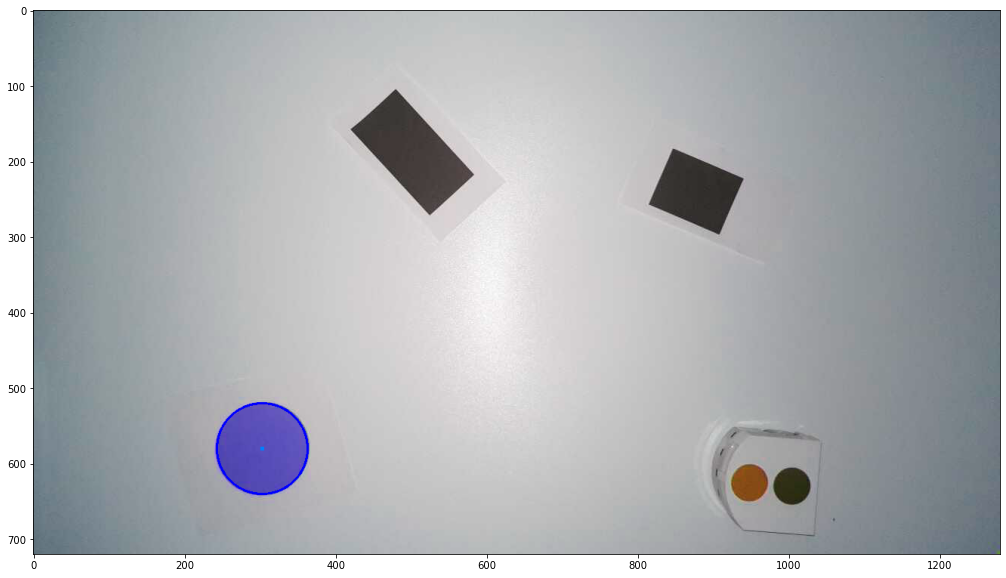

In [6]:
%matplotlib inline
frame = raw_frame.copy()
robot_front_absolute, front_image = vision.find_thymio_front(frame)
robot_center_absolute, center_image = vision.find_thymio_center(frame)
destination_center_absolute, destination_image = vision.find_destination_center(frame)
plt.figure(figsize = (50,10))
plt.imshow(front_image)
plt.show()
plt.figure(figsize = (50,10))
plt.imshow(center_image)
plt.show()
plt.figure(figsize = (50,10))
plt.imshow(destination_image)
plt.show()

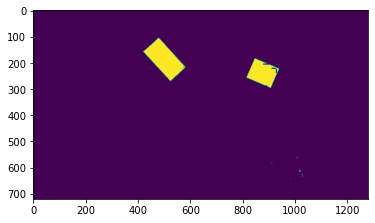

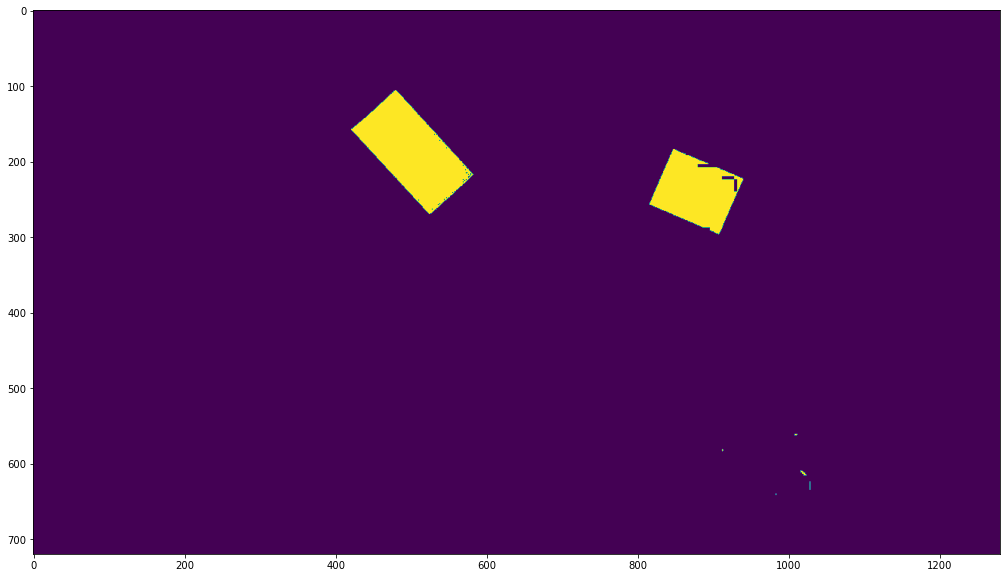

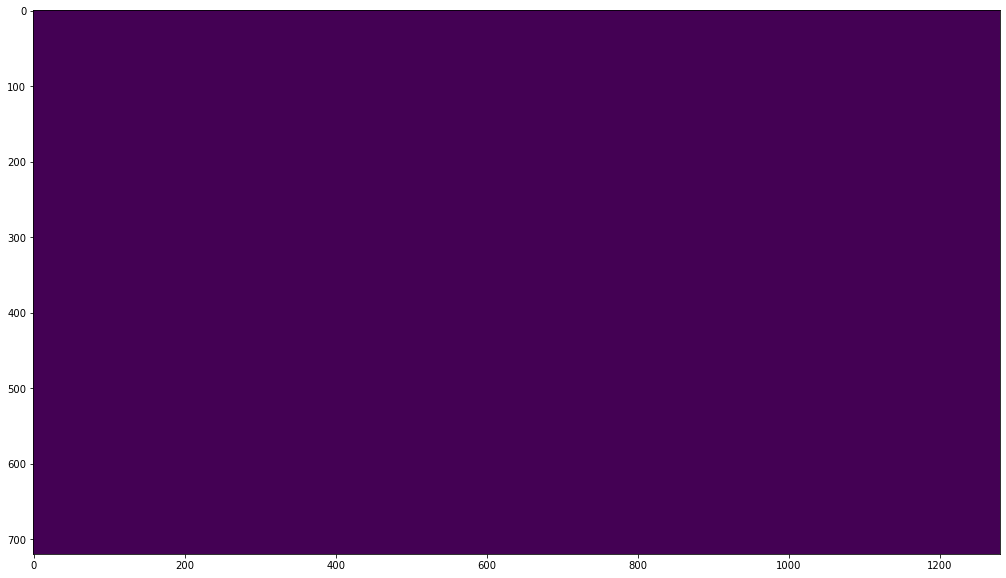

In [27]:
%matplotlib inline
importlib.reload(vision)
output_objects = vision.find_objects(frame)
output_objects = cv2.cvtColor(output_objects, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (50,10))
plt.imshow(output_objects)
plt.show()

In [36]:
def display_occupancy_grid(output_objects):
    test = output_objects.copy()
    compressed = cv2.resize(test, (0, 0), fx = 0.0694, fy = 0.0694) 
    #plt.imshow(compressed)
    #Creating the grid
    max_val = 50 # Size of the map
    fig, ax = create_empty_plot(max_val)
    # Creating the occupancy grid
    data = compressed.copy() # Create a grid of 67 x 50 with objects values
    #print(data)
    cmap = colors.ListedColormap(['white', 'black']) # Select the colors with which to display obstacles and free cells
    # Converting the random values into occupied and free cells
    limit = 10
    occupancy_grid = data.copy()
    #occupancy_grid_flipped = cv2.flip(occupancy_grid, flipCode = 0)
    occupancy_grid[data>limit] = 1
    occupancy_grid[data<=limit] = 0
    # Displaying the map
    ax.imshow(cv2.flip(occupancy_grid, 0))
    plt.title("Map : free cells in white, occupied cells in black");
    return occupancy_grid, cmap

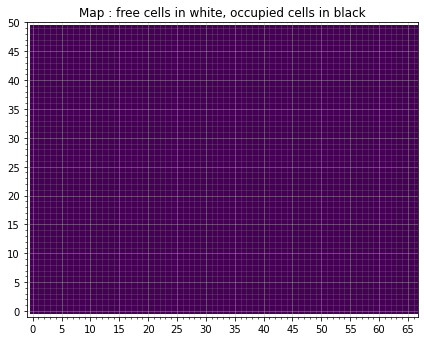

In [37]:
occupancy_grid, cmap = display_occupancy_grid(output_objects)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29, 30, 31, 31, 32, 32, 32, 33]])

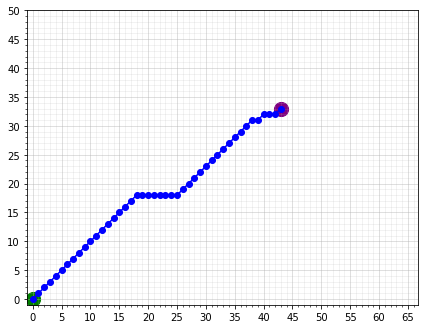

In [38]:
# Define the start and end goal
start = (0,0)
goal = (43,33)
max_val = 50

runAstar(start, goal, max_val, occupancy_grid, cmap)

In [13]:
def analyze():
    print("ANALYSING")
    cap = cv2.VideoCapture(2)
    ret, raw_frame = cap.read()
    frame = raw_frame.copy()
    
    # Find robot and destination positions
    robot_center_absolute = find_thymio_center(frame)
    robot_front_absolute = find_thymio_front(frame)
    destination_center_aboslute = find_destination_center(frame)
    
    # Detect obstacles positions
    # Read image with obstacles as black rectangles
    frame_objects = frame.copy()
    test = find_objects(frame_objects)
    
    test_dilated = cv2.dilate(test, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))
    ret,thresh = cv2.threshold(test,10,255,0) 

    # Combine all
    THYMIO_WIDTH = 92
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (THYMIO_WIDTH, THYMIO_WIDTH))
    dilated = cv2.dilate(test, kernel)
    compressed = cv2.resize(test, (0, 0), fx = 0.0694, fy = 0.0694) 
    #Creating the grid
    max_val = 50 # Size of the map
    fig, ax = create_empty_plot(67,50)
    # Creating the occupancy grid
    np.random.seed(0) # To guarantee the same outcome on all computers
    data = compressed * 20 # Create a grid of 67 x 50 with objects values
    cmap = colors.ListedColormap(['white', 'black']) # Select the colors with which to display obstacles and free cells
    # Converting the random values into occupied and free cells
    limit = 10 
    occupancy_grid = data.copy()
    #occupancy_grid_flipped = cv2.flip(occupancy_grid, flipCode = 0)
    occupancy_grid[data>limit] = 1
    occupancy_grid[data<=limit] = 0
    # Displaying the map
    ax.imshow(cv2.flip(occupancy_grid, 0), cmap=cmap)
    plt.title("Map : free cells in white, occupied cells in black");

    # Define the start and end goal
    start = (int(robot_center_absolute[0]*0.0694), int(robot_center_absolute[1]*0.0694))#(int(robot_center_absolute[0]*0.0694),int(50-robot_center_absolute[1]*0.0694))
    goal = (int(destination_center_absolute[0]*0.0694), int(destination_center_absolute[1]*0.0694))
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE - 
    # EXECUTION AND PLOTTING OF THE ALGORITHM
    # -----------------------------------------
    # List of all coordinates in the grid
    x,y = np.mgrid[0:max_val:1, 0:max_val:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])
    # Define the heuristic, here = distance to goal ignoring obstacles
    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))
    # Run the A* algorithm
    path, visitedNodes = A_Star(start, goal, h, coords, cv2.flip(occupancy_grid, 0).transpose(), movement_type="8N")
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
    # Displaying the map
    fig_astar, ax_astar = create_empty_plot(67,50)
    ax_astar.imshow(cv2.flip(occupancy_grid, 0), cmap=cmap)
    # Plot the best path found and the list of visited nodes
    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    return robot_front_absolute, robot_center_absolute, destination_center_absolute, path


In [15]:
def dist(current_x, current_y, goal_x, goal_y):
    return np.sqrt((goal_x-current_x)**2-(goal_y-current_y)**2), 


# MOVE THYMIO

In [7]:
th = Thymio.serial(port="COM9", refreshing_rate=0.1)

### Calculate Thymio angle

In [8]:
print(robot_center_absolute)
print(robot_front_absolute)

NameError: name 'robot_center_absolute' is not defined

In [27]:
robot_center_absolute[0]

NameError: name 'robot_center_absolute' is not defined

In [9]:
def angleCalculator(robot_front_absolute, robot_center_absolute, destination_center_absolute):
    angleRobotAbsolute = np.arctan2(robot_front_absolute[1] - robot_center_absolute[1], robot_front_absolute[0] - robot_center_absolute[0])
    #print("Robot : ", np.rad2deg(angleRobotAbsolute))
    angleGoalAbsolute = np.arctan2(destination_center_absolute[1] - robot_center_absolute[1], destination_center_absolute[0] - robot_center_absolute[0])
    #print("Angle goal absolute:", np.rad2deg(angleGoalAbsolute))
    return np.rad2deg(angleGoalAbsolute - angleRobotAbsolute)%360
def distanceCalculator(current_x, current_y, goal_x, goal_y):
    return np.sqrt((goal_x-current_x)**2-(goal_y-current_y)**2), 

In [ ]:
MOVING = True
pointID = 0
angleReached = False
distanceReached = False
th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)
robot_front_absolute, robot_center_absolute, destination_center_absolute, path = analyze()
#print(robot_center_absolute)
while(MOVING):
    angleToRotate = angleCalculator(robot_front_absolute, robot_center_absolute, [path[0][pointID],path[1][pointID]])
    print(angleToRotate)
    if (abs(angleToRotate)<5):
        th.set_var("motor.left.target", 0)
        th.set_var("motor.right.target", 0)
        angleReached = True
    if not(angleReached):
        th.set_var("motor.left.target", 30)
        th.set_var("motor.right.target", 2**16 -30)
    else:
        distanceToGoal = distanceCalculator(robot_center_absolute[0],robot_center_absolute[1],robot_center_absolute, path[0][pointID], path[1][pointID])
        if (abs(distanceToGoal)<3):
            th.set_var("motor.left.target", 0)
            th.set_var("motor.right.target", 0)
            distanceReached = True
            pointID = pointID + 1
            if (pointID > len(path[0])):
                MOVING = False
        if not (distanceReached):
            th.set_var("motor.left.target", 30)
            th.set_var("motor.right.target", 2**16 - 30)
    robot_front_absolute, robot_center_absolute, destination_center_absolute, _ = analyze()
    #print(robot_front_absolute)

In [477]:
th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)

th.set_var("motor.left.target", 2**16-200)
th.set_var("motor.right.target", 2**16-200)

time.sleep()

th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)

In [157]:
th.set_var('motor.left.target', 0)